In [135]:
# Author: Pradeep Kumar

# Loading required libraries

import pandas as pd  # Data manipulation and analysis
import numpy as np  # Numerical operations
import seaborn as sns  # Statistical data visualization
from collections import Counter  # Count hashable objects
import matplotlib.pyplot as plt  # Plotting library
from matplotlib import cm  # Colormap and color information
import os  # Operating system interfaces
import warnings  # Warning control
import re  # Regular expression operations
from scipy.stats import pearsonr  # Pearson correlation coefficient

warnings.filterwarnings("ignore")  # Suppress warnings

In [136]:
# Define file paths
voting_path = r"Data\Kiesraad"

distance_100_gemeente = r"Analyse\gemeente_level_100"
distance_100_wijk = r"Analyse\wijk_level_100"

distance_500_gemeente = r"Analyse\gemeente_level_500"
distance_500_wijk = r"Analyse\wijk_level_500"

CBS_Path = r"Data\CBS\Kerncijfers wijken en buurten\KWB"

# Define data files
voting_file_wijk = r"\opkomst_per_stembureau_EP2024_wijk.xlsx"
CBS_file = r"\kwb-2022.xlsx"
distance_gemeente_file = r"\distances_on_gemeentelevel.xlsx"
distance_wijk_file = r"\distances_on_wijklevel.xlsx"


voting_file_gm = r"\OPkomst_EP2024_corrected.csv"

In [137]:
# Load CBS data and map t0 2024
columns_selection = ['gwb_code_10','regio','gm_naam','recs','a_inw','a_opl_lg','a_opl_md','a_opl_hg','g_hh_sti'] #voting_file_gm'
cbs_data = pd.read_excel(CBS_Path + CBS_file)

# Replace specified municipalities with the new municipality name
replacement_dict_name = {
    'Brielle': 'Voorne aan Zee',
    'Hellevoetsluis': 'Voorne aan Zee',
    'Westvoorne': 'Voorne aan Zee',
    'Weesp':'Amsterdam'
}

replacement_dict_code = {
    'GM0501': 'GM1992',
    'GM0530': 'GM1992',
    'GM0614': 'GM1992',
    'GM0457':'GM0363'
}

cbs_data['gm_naam'] = cbs_data['gm_naam'].replace(replacement_dict_name)
cbs_data['regio'] = cbs_data['regio'].replace(replacement_dict_name)
cbs_data['gwb_code_10'] = cbs_data['gwb_code_10'].replace(replacement_dict_code)


cbs_data_wijk = cbs_data[cbs_data.recs=='Wijk'][columns_selection]
cbs_data_gemeente = cbs_data[cbs_data.recs=='Gemeente'][columns_selection]

# Convert all relevant columns to numeric, coercing errors to NaN
columns_to_convert = ['g_hh_sti', 'a_inw', 'a_opl_lg', 'a_opl_md', 'a_opl_hg']
cbs_data_gemeente[columns_to_convert] = cbs_data_gemeente[columns_to_convert].apply(pd.to_numeric, errors='coerce')

cbs_data_gemeente = cbs_data_gemeente.groupby(['gwb_code_10', 'regio', 'gm_naam', 'recs']).agg({
    'a_inw': 'sum',
    'a_opl_lg': 'sum',
    'a_opl_md': 'sum',
    'a_opl_hg': 'sum',
    'g_hh_sti': 'mean'
}).reset_index()

In [138]:
# Load election data at wijk level

voting_data_wijk =  pd.read_excel(voting_path + voting_file_wijk)
voting_data_wijk['wijkcode2022'] = voting_data_wijk['wijkcode2022'].apply(lambda x: f"WK{x:06}")
print(voting_data_wijk.shape)
print(f"Number of wijks: {voting_data_wijk['wijknaam2022'].nunique()}")

(9665, 16)
Number of wijks: 2699


In [139]:
# Subsetting the relevant columns from the voting_data_wijk dataframe
voting_data_wijk_subset = voting_data_wijk[['Wijk2022', 'wijknaam2022', 'wijkcode2022','gemeenteId', 'kiesgerechtigden', 'uitgebrachte_stemmen']]

# Grouping by 'Wijk2022', 'wijknaam2022', and 'gemeenteId', then summing the remaining columns and resetting the index
voting_data_wijk_grouped = voting_data_wijk_subset.groupby(['Wijk2022','wijkcode2022' ,'wijknaam2022', 'gemeenteId']).sum().reset_index()

# Getting the shape of the subset dataframe
voting_data_wijk_grouped.shape

(2832, 6)

In [140]:
# Load distance data

gm_columns = ['gemeente','gemeentecode','inwoners','woningwaarde','uitkering','dist_mean','dist_median']

gm_500 = pd.read_excel(distance_500_gemeente + distance_gemeente_file)[gm_columns]
wijk_500 = pd.read_excel(distance_500_wijk + distance_wijk_file)
gm_100 = pd.read_excel(distance_100_gemeente + distance_gemeente_file)[gm_columns]
wijk_100 = pd.read_excel(distance_100_wijk + distance_wijk_file)

gm_500['gemeentecode'] = gm_500['gemeentecode'].apply(lambda x: f"GM{x:04}")
gm_100['gemeentecode'] = gm_100['gemeentecode'].apply(lambda x: f"GM{x:04}")

wijk_500['Wijkcode'] = wijk_500['Wijkcode'].apply(lambda x: f"WK{x:06}")
wijk_100['Wijkcode'] = wijk_100['Wijkcode'].apply(lambda x: f"WK{x:06}")


# Print the shapes of the dataframes
print("Shape of gm_500:", gm_500.shape)
print("Shape of wijk_500:", wijk_500.shape)
print("Shape of gm_100:", gm_100.shape)
print("Shape of wijk_100:", wijk_100.shape)

# merge these file with CBS data
gm_500_cbs = pd.merge(gm_500,cbs_data_gemeente, left_on = 'gemeentecode', right_on = 'gwb_code_10')
gm_100_cbs = pd.merge(gm_100,cbs_data_gemeente, left_on = 'gemeentecode', right_on = 'gwb_code_10')

wijk_500_cbs = pd.merge(wijk_500,cbs_data_wijk, left_on = ['Wijkcode'], right_on = ['gwb_code_10'])
wijk_100_cbs = pd.merge(wijk_100,cbs_data_wijk, left_on =  ['Wijkcode'], right_on = ['gwb_code_10'])


# Print the shapes of the dataframes
print("Shape of gm_500_cbs:", gm_500_cbs.shape)
print("Shape of gm_100_cbs:", gm_100_cbs.shape)
print("Shape of wijk_500_cbs:", wijk_500_cbs.shape)
print("Shape of wijk_100_cbs:", wijk_100_cbs.shape)


Shape of gm_500: (342, 7)
Shape of wijk_500: (3347, 10)
Shape of gm_100: (342, 7)
Shape of wijk_100: (3361, 10)
Shape of gm_500_cbs: (342, 16)
Shape of gm_100_cbs: (342, 16)
Shape of wijk_500_cbs: (3313, 19)
Shape of wijk_100_cbs: (3307, 19)


# Wijk level analysis

In [153]:
# Merge voting data with Wijk data

# place holder

select_wiijk = wijk_500_cbs # wijk_500_cbs, 'wijk_100_cbs'
_suffix = '_500' #'_500', '_100'

voting_data_wijk_100 = pd.merge(voting_data_wijk_grouped,select_wiijk,left_on ='wijkcode2022', right_on ='Wijkcode')
voting_data_wijk_100.shape

(2821, 25)

In [154]:
## correlation study at Wijk level

# Filter out rows where 'kiesgerechtigden' is less than or equal to zero
voting_data_wijk_100_non_zero = voting_data_wijk_100[voting_data_wijk_100['kiesgerechtigden'] > 0]

# Convert necessary columns to numeric, forcing errors to NaN
cols_to_convert = ['kiesgerechtigden', 'uitgebrachte_stemmen', 'a_opl_lg', 'a_opl_md', 'a_opl_hg', 'a_inw']
for col in cols_to_convert:
    voting_data_wijk_100_non_zero[col] = pd.to_numeric(voting_data_wijk_100_non_zero[col], errors='coerce')

# Calculate the voter turnout
voting_data_wijk_100_non_zero['opkomst'] = voting_data_wijk_100_non_zero['uitgebrachte_stemmen'] / voting_data_wijk_100_non_zero['kiesgerechtigden']*100

# Compute the proportion of residents with different levels of education
voting_data_wijk_100_non_zero['a_opl_lgn'] = voting_data_wijk_100_non_zero['a_opl_lg'] / voting_data_wijk_100_non_zero['a_inw']*100
voting_data_wijk_100_non_zero['a_opl_mdn'] = voting_data_wijk_100_non_zero['a_opl_md'] / voting_data_wijk_100_non_zero['a_inw']*100
voting_data_wijk_100_non_zero['a_opl_hgn'] = voting_data_wijk_100_non_zero['a_opl_hg'] / voting_data_wijk_100_non_zero['a_inw']*100


In [155]:
print(voting_data_wijk_100_non_zero.wijknaam2022.nunique())

2355


## Education

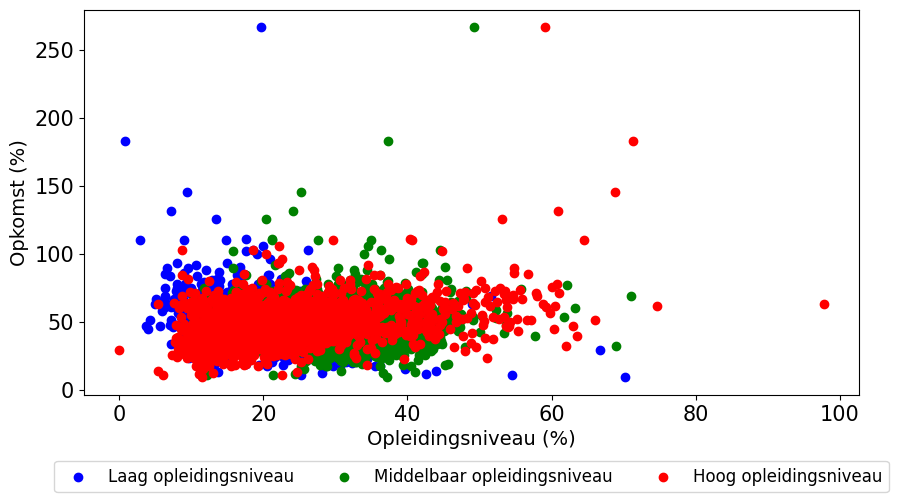

In [156]:
# Drop rows with NaN or infinite values
voting_data_wijk_100_non_zero = voting_data_wijk_100_non_zero.replace([np.inf, -np.inf], np.nan).dropna()

# Create scatter plots
plt.figure(figsize=(10, 5))

# Scatter plots
plt.scatter(voting_data_wijk_100_non_zero['a_opl_lgn'], voting_data_wijk_100_non_zero['opkomst'], label='Laag opleidingsniveau', color='blue', alpha=1)
plt.scatter(voting_data_wijk_100_non_zero['a_opl_mdn'], voting_data_wijk_100_non_zero['opkomst'], label='Middelbaar opleidingsniveau', color='green', alpha=1)
plt.scatter(voting_data_wijk_100_non_zero['a_opl_hgn'], voting_data_wijk_100_non_zero['opkomst'], label='Hoog opleidingsniveau', color='red', alpha=1)

# Adding KDE plots
#sns.kdeplot(x=voting_data_wijk_100_non_zero['a_opl_lgn'], y=voting_data_wijk_100_non_zero['opkomst'], color='blue', alpha=0.1, fill=True)
#sns.kdeplot(x=voting_data_wijk_100_non_zero['a_opl_mdn'], y=voting_data_wijk_100_non_zero['opkomst'], color='green', alpha=0.1, fill=True)
#sns.kdeplot(x=voting_data_wijk_100_non_zero['a_opl_hgn'], y=voting_data_wijk_100_non_zero['opkomst'], color='red', alpha=0.1, fill=True)

# Adding labels and legend in Dutch with text size adjustments
plt.xlabel('Opleidingsniveau (%)', fontsize=14)
plt.ylabel('Opkomst (%)', fontsize=14)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fontsize=12, ncol=3)
#plt.title('Opleiding vs. Opkomst', fontsize=16)
# Adjusting tick size
plt.tick_params(axis='both', which='major', labelsize=15)

plt.savefig("Analyse//Wijk_opkomst//Education"+_suffix+".png", format='png', dpi=500, bbox_inches='tight', transparent=True)
# Show plot
plt.show()

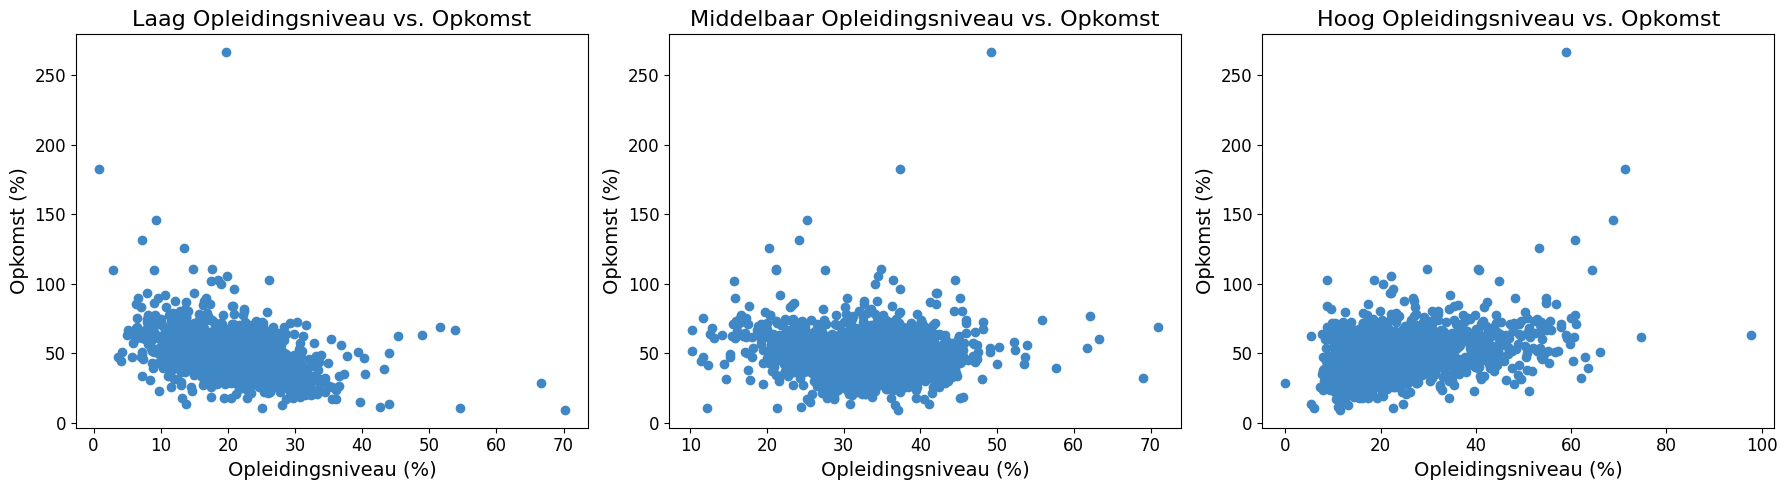

In [157]:
# Drop rows with NaN or infinite values
voting_data_wijk_100_non_zero = voting_data_wijk_100_non_zero.replace([np.inf, -np.inf], np.nan).dropna()

# Create a figure for subplots
plt.figure(figsize=(18, 5))

# Subplot 1: Laag opleidingsniveau
plt.subplot(1, 3, 1)
plt.scatter(voting_data_wijk_100_non_zero['a_opl_lgn'], voting_data_wijk_100_non_zero['opkomst'], label='Laag opleidingsniveau', color='#3f88c5', alpha=1)
plt.xlabel('Opleidingsniveau (%)', fontsize=14)
plt.ylabel('Opkomst (%)', fontsize=14)
#plt.legend(loc='upper left', fontsize=12)
plt.title('Laag Opleidingsniveau vs. Opkomst', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=12)

# Subplot 2: Middelbaar opleidingsniveau
plt.subplot(1, 3, 2)
plt.scatter(voting_data_wijk_100_non_zero['a_opl_mdn'], voting_data_wijk_100_non_zero['opkomst'], label='Middelbaar opleidingsniveau', color='#3f88c5', alpha=1)
plt.xlabel('Opleidingsniveau (%)', fontsize=14)
plt.ylabel('Opkomst (%)', fontsize=14)
#plt.legend(loc='upper left', fontsize=12)
plt.title('Middelbaar Opleidingsniveau vs. Opkomst', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=12)

# Subplot 3: Hoog opleidingsniveau
plt.subplot(1, 3, 3)
plt.scatter(voting_data_wijk_100_non_zero['a_opl_hgn'], voting_data_wijk_100_non_zero['opkomst'], label='Hoog opleidingsniveau', color='#3f88c5', alpha=1)
plt.xlabel('Opleidingsniveau (%)', fontsize=14)
plt.ylabel('Opkomst (%)', fontsize=14)
#plt.legend(loc='upper left', fontsize=12)
plt.title('Hoog Opleidingsniveau vs. Opkomst', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=12)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.savefig("Analyse///Wijk_opkomst//Education_subplot"+_suffix+".png", format='png', dpi=500, bbox_inches='tight', transparent=True)

# Show plot
plt.show()

In [158]:
for edu in ['a_opl_lgn', 'a_opl_mdn', 'a_opl_hgn']:
    # Calculate and print Pearson correlation coefficient and p-value 
    ed_pearsonr = pearsonr(voting_data_wijk_100_non_zero[edu], voting_data_wijk_100_non_zero['opkomst'])
    print(f"Pearson correlation (education and turnout): Coefficient = {ed_pearsonr[0]:.3f}, p-value = {ed_pearsonr[1]:.3g},education_level  = {edu}{_suffix}")


Pearson correlation (education and turnout): Coefficient = -0.427, p-value = 2.54e-107,education_level  = a_opl_lgn_500
Pearson correlation (education and turnout): Coefficient = -0.077, p-value = 0.000168,education_level  = a_opl_mdn_500
Pearson correlation (education and turnout): Coefficient = 0.354, p-value = 4.12e-72,education_level  = a_opl_hgn_500


## Income

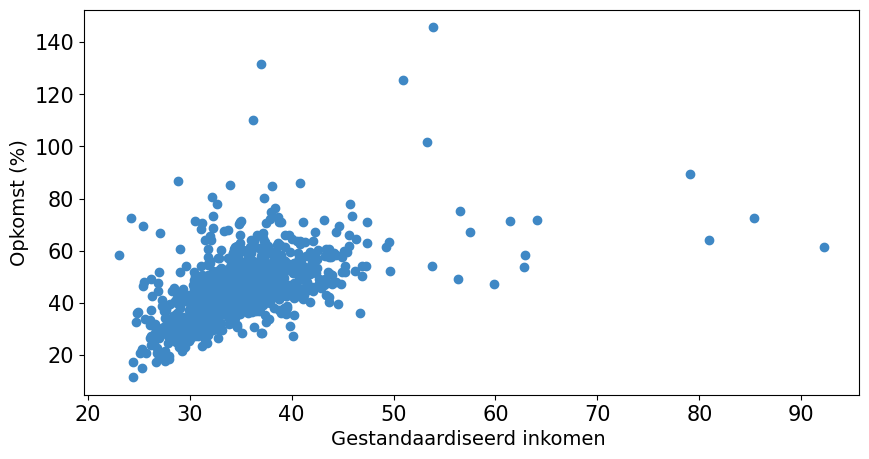

In [159]:
# Drop rows with NaN or infinite values
voting_data_wijk_100_non_zero_income = voting_data_wijk_100_non_zero.replace([np.inf, -np.inf], np.nan).dropna()
voting_data_wijk_100_non_zero_income = voting_data_wijk_100_non_zero_income.dropna()
voting_data_wijk_100_non_zero_income['g_hh_sti'] = pd.to_numeric(voting_data_wijk_100_non_zero['g_hh_sti'], errors='coerce')
# Create scatter plots
plt.figure(figsize=(10, 5))

# Scatter plots
plt.scatter(voting_data_wijk_100_non_zero_income['g_hh_sti'], voting_data_wijk_100_non_zero_income['opkomst'], color = '#3f88c5', alpha=1)

# Adding KDE plots
#sns.kdeplot(x=voting_data_wijk_100_non_zero['a_opl_lgn'], y=voting_data_wijk_100_non_zero['opkomst'], color='blue', alpha=0.1, fill=True)

# Adding labels and legend in Dutch with text size adjustments
plt.xlabel('Gestandaardiseerd inkomen ', fontsize=14)
plt.ylabel('Opkomst (%)', fontsize=14)
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fontsize=12, ncol=3)
#plt.title('Inkomen  vs. Opkomst', fontsize=16)
# Adjusting tick size
plt.tick_params(axis='both', which='major', labelsize=15)

plt.savefig("Analyse///Wijk_opkomst//Income"+_suffix+".png", format='png', dpi=500, bbox_inches='tight', transparent=True)
# Show plot
plt.show()

In [160]:
ink = "g_hh_sti"
voting_data_wijk_100_non_zero_income = voting_data_wijk_100_non_zero_income.dropna(subset = 'g_hh_sti')
income_pearsonr = pearsonr(voting_data_wijk_100_non_zero_income['g_hh_sti'], voting_data_wijk_100_non_zero_income['opkomst'])
print(f"Pearson correlation (income and turnout): Coefficient = {income_pearsonr[0]:.3f}, p-value = {income_pearsonr[1]:.3g},income_level  = {ink}{_suffix}")


Pearson correlation (income and turnout): Coefficient = 0.509, p-value = 4.91e-63,income_level  = g_hh_sti_500


## Distance

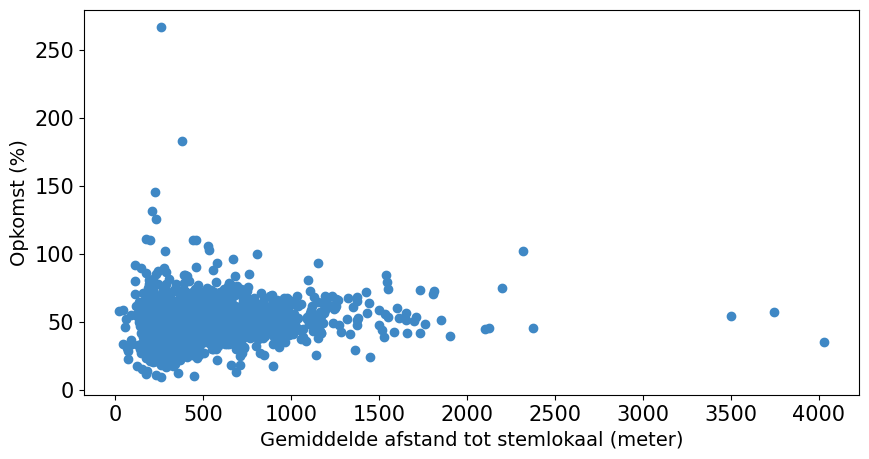

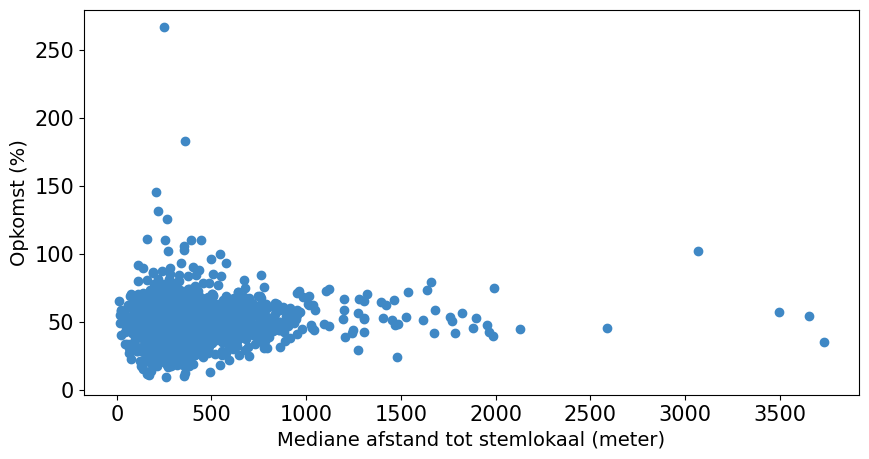

In [161]:
for _dist in ['dist_mean', 'dist_median']:
    voting_data_wijk_100_non_zero_dist = voting_data_wijk_100_non_zero.replace([np.inf, -np.inf], np.nan).dropna()
    voting_data_wijk_100_non_zero_dist = voting_data_wijk_100_non_zero_dist.dropna()

    if _dist=='dist_median':
        d = 'Mediane afstand tot stemlokaal (meter)'
    else:
        d = 'Gemiddelde afstand tot stemlokaal (meter)'
        
    plt.figure(figsize=(10, 5))     

    # Scatter plots
    plt.scatter(voting_data_wijk_100_non_zero_dist[_dist], voting_data_wijk_100_non_zero_dist['opkomst'], color = '#3f88c5', alpha=1)


    # Adding labels and legend in Dutch with text size adjustments
    plt.xlabel(d, fontsize=14)
    plt.ylabel('Opkomst (%)', fontsize=14)
    # Adjusting tick size
    plt.tick_params(axis='both', which='major', labelsize=15)

    plt.savefig("Analyse///Wijk_opkomst//"+_dist+_suffix+".png", format='png', dpi=500, bbox_inches='tight', transparent=True)
    plt.show()

In [162]:
# Calculate and print Pearson correlation coefficient and p-value for mean distance and turnout fraction
mean_distance_pearsonr = pearsonr(voting_data_wijk_100_non_zero_dist['dist_mean'], voting_data_wijk_100_non_zero_dist['opkomst'])
print(f"Pearson correlation (mean distance and turnout): Coefficient = {mean_distance_pearsonr[0]:.3f}, p-value = {mean_distance_pearsonr[1]:.3g},type_  = {_suffix}")

# Calculate and print Pearson correlation coefficient and p-value for median distance and turnout fraction
median_distance_pearsonr = pearsonr(voting_data_wijk_100_non_zero_dist['dist_median'], voting_data_wijk_100_non_zero_dist['opkomst'])
print(f"Pearson correlation (median distance and turnout): Coefficient = {median_distance_pearsonr[0]:.3f}, p-value = {median_distance_pearsonr[1]:.3g}, type_ = {_suffix}")

Pearson correlation (mean distance and turnout): Coefficient = 0.158, p-value = 6.35e-15,type_  = _500
Pearson correlation (median distance and turnout): Coefficient = 0.093, p-value = 5.27e-06, type_ = _500


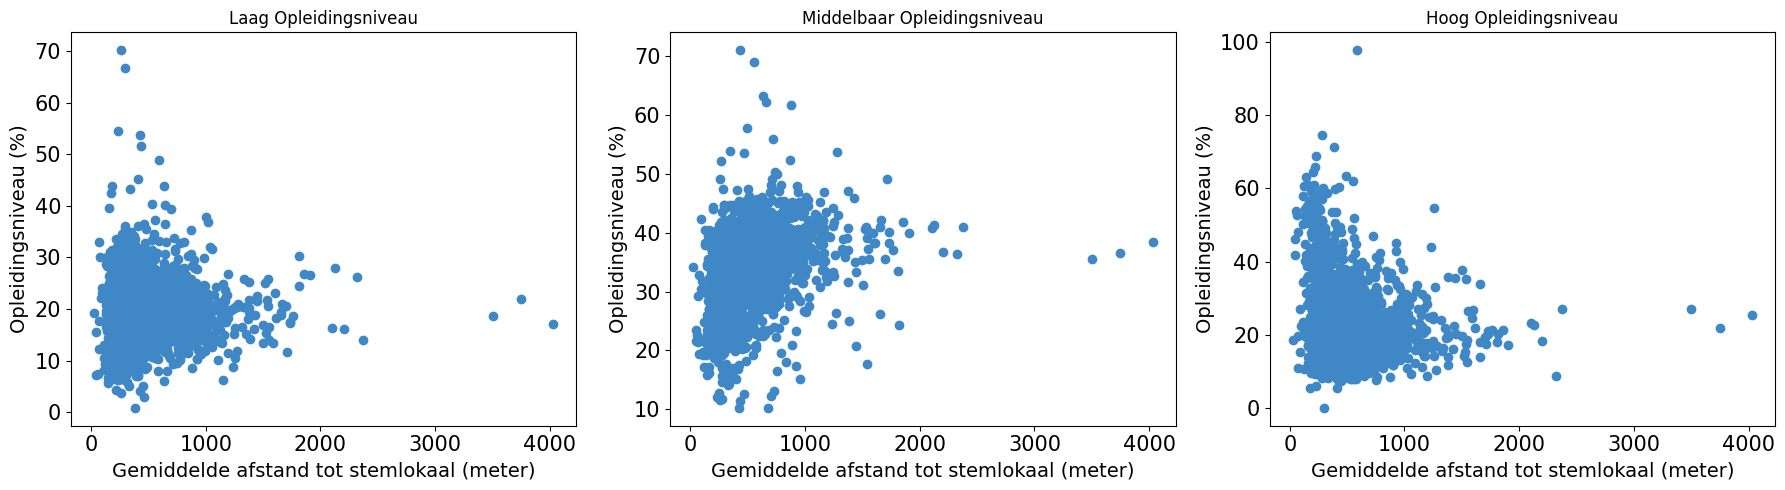

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


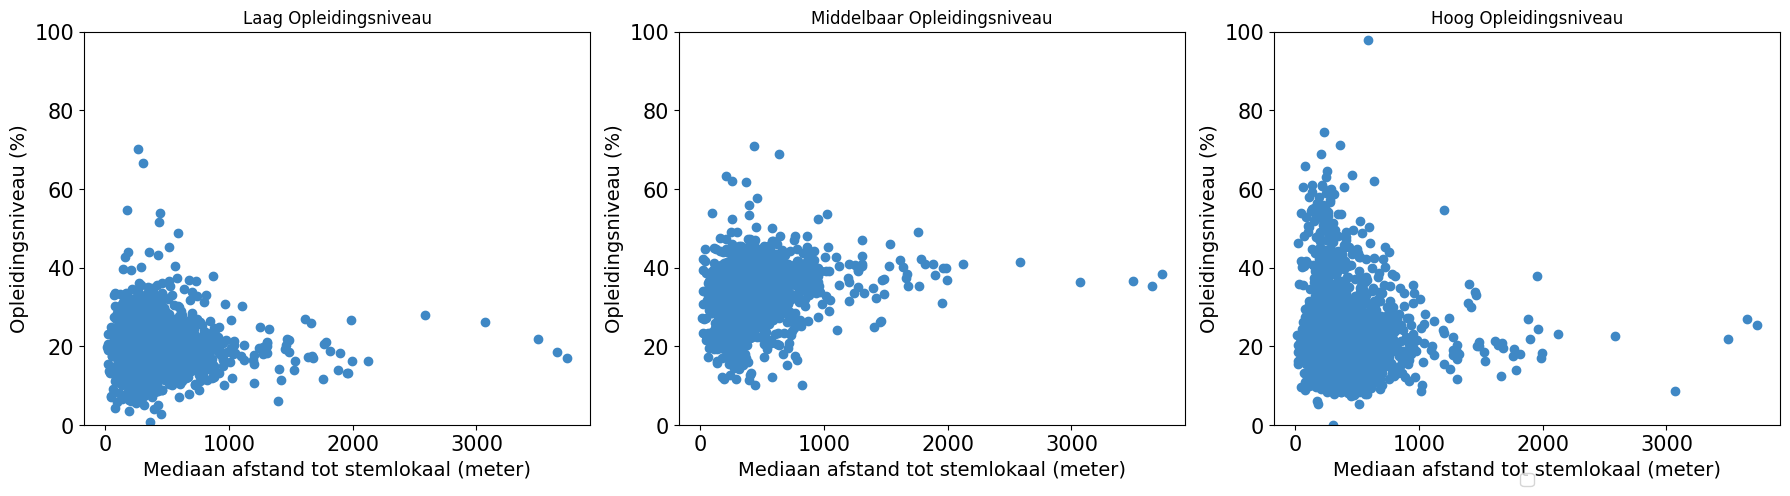

In [163]:
voting_data_wijk_100_non_zero_dist[['dist_mean','dist_median','a_opl_lg', 'a_opl_md', 'a_opl_hg','g_hh_sti']].corr()


# Define the figure size and the subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# First subplot for Laag opleidingsniveau
ax1.scatter(voting_data_wijk_100_non_zero['dist_mean'], voting_data_wijk_100_non_zero['a_opl_lgn'], color='#3f88c5', alpha=1)
ax1.set_ylabel('Opleidingsniveau (%)', fontsize=14)
ax1.set_xlabel('Gemiddelde afstand tot stemlokaal (meter)', fontsize=14)
ax1.set_title('Laag Opleidingsniveau')
ax1.tick_params(axis='both', which='major', labelsize=15)

# Second subplot for Middelbaar opleidingsniveau
ax2.scatter(voting_data_wijk_100_non_zero['dist_mean'], voting_data_wijk_100_non_zero['a_opl_mdn'], color='#3f88c5', alpha=1)
ax2.set_ylabel('Opleidingsniveau (%)', fontsize=14)
ax2.set_xlabel('Gemiddelde afstand tot stemlokaal (meter)', fontsize=14)
ax2.set_title('Middelbaar Opleidingsniveau')
ax2.tick_params(axis='both', which='major', labelsize=15)

# Third subplot for Hoog opleidingsniveau
ax3.scatter(voting_data_wijk_100_non_zero['dist_mean'], voting_data_wijk_100_non_zero['a_opl_hgn'], color='#3f88c5', alpha=1)
ax3.set_ylabel('Opleidingsniveau (%)', fontsize=14)
ax3.set_xlabel('Gemiddelde afstand tot stemlokaal (meter)', fontsize=14)
ax3.set_title('Hoog Opleidingsniveau')
ax3.tick_params(axis='both', which='major', labelsize=15)

# Adjust layout to prevent overlap
plt.tight_layout()

plt.savefig("Analyse///Wijk_spread//dist_mean_Education_subplot"+_suffix+".png", format='png', dpi=500, bbox_inches='tight', transparent=True)

# Show plot
plt.show()

# Define the figure size and the subplots in 1 row and 3 columns
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# First subplot for Laag opleidingsniveau
ax1.scatter(voting_data_wijk_100_non_zero['dist_median'], voting_data_wijk_100_non_zero['a_opl_lgn'], color='#3f88c5', alpha=1)
ax1.set_ylabel('Opleidingsniveau (%)', fontsize=14)
ax1.set_xlabel('Mediaan afstand tot stemlokaal (meter)', fontsize=14)
ax1.set_title('Laag Opleidingsniveau')
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.set_ylim(0, 100)

# Second subplot for Middelbaar opleidingsniveau
ax2.scatter(voting_data_wijk_100_non_zero['dist_median'], voting_data_wijk_100_non_zero['a_opl_mdn'], color='#3f88c5', alpha=1)
ax2.set_ylabel('Opleidingsniveau (%)', fontsize=14)
ax2.set_xlabel('Mediaan afstand tot stemlokaal (meter)', fontsize=14)
ax2.set_title('Middelbaar Opleidingsniveau')
ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.set_ylim(0, 100)

# Third subplot for Hoog opleidingsniveau
ax3.scatter(voting_data_wijk_100_non_zero['dist_median'], voting_data_wijk_100_non_zero['a_opl_hgn'], color='#3f88c5', alpha=1)
ax3.set_ylabel('Opleidingsniveau (%)', fontsize=14)
ax3.set_xlabel('Mediaan afstand tot stemlokaal (meter)', fontsize=14)
ax3.set_title('Hoog Opleidingsniveau')
ax3.tick_params(axis='both', which='major', labelsize=15)
ax3.set_ylim(0, 100)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fontsize=12, ncol=3)

plt.savefig("Analyse///Wijk_spread//dist_median_Education_subplot"+_suffix+".png", format='png', dpi=500, bbox_inches='tight', transparent=True)
# Show plot
plt.show()


In [164]:
for edu in ['a_opl_lg', 'a_opl_md', 'a_opl_hg']:
    # Calculate and print Pearson correlation coefficient and p-value 
    ed_pearsonr = pearsonr(voting_data_wijk_100_non_zero[edu], voting_data_wijk_100_non_zero['dist_mean'])
    print(f"Pearson correlation (education and dist_mean): Coefficient = {ed_pearsonr[0]:.3f}, p-value = {ed_pearsonr[1]:.3g},education_level  = {edu}{_suffix}")
    ed_pearsonr = pearsonr(voting_data_wijk_100_non_zero[edu], voting_data_wijk_100_non_zero['dist_median'])
    print(f"Pearson correlation (education and dist_median): Coefficient = {ed_pearsonr[0]:.3f}, p-value = {ed_pearsonr[1]:.3g},education_level  = {edu}{_suffix}")

voting_data_wijk_100_non_zero_wo_nan = voting_data_wijk_100_non_zero[voting_data_wijk_100_non_zero['g_hh_sti']!='.']    
ed_pearsonr = pearsonr(voting_data_wijk_100_non_zero_wo_nan['g_hh_sti'], voting_data_wijk_100_non_zero_wo_nan['dist_median'])
print(f"Pearson correlation (income and dist_median): Coefficient = {ed_pearsonr[0]:.3f}, p-value = {ed_pearsonr[1]:.3g}")

ed_pearsonr = pearsonr(voting_data_wijk_100_non_zero_wo_nan['g_hh_sti'], voting_data_wijk_100_non_zero_wo_nan['dist_mean'])
print(f"Pearson correlation (income and dist_mean): Coefficient = {ed_pearsonr[0]:.3f}, p-value = {ed_pearsonr[1]:.3g}")


Pearson correlation (education and dist_mean): Coefficient = -0.293, p-value = 6.31e-49,education_level  = a_opl_lg_500
Pearson correlation (education and dist_median): Coefficient = -0.217, p-value = 3.81e-27,education_level  = a_opl_lg_500
Pearson correlation (education and dist_mean): Coefficient = -0.301, p-value = 7.38e-52,education_level  = a_opl_md_500
Pearson correlation (education and dist_median): Coefficient = -0.224, p-value = 6.22e-29,education_level  = a_opl_md_500
Pearson correlation (education and dist_mean): Coefficient = -0.322, p-value = 3.93e-59,education_level  = a_opl_hg_500
Pearson correlation (education and dist_median): Coefficient = -0.235, p-value = 1.5e-31,education_level  = a_opl_hg_500
Pearson correlation (income and dist_median): Coefficient = 0.161, p-value = 6.85e-07
Pearson correlation (income and dist_mean): Coefficient = 0.197, p-value = 1.09e-09


# Gemeente

In [123]:
# Merge voting data with gemeente data

# place holder

select_gm = gm_500_cbs # gm_100_cbs, gm_500_cbs
_suffix_gm = '_500' #'_100', '_500'

voting_data_gm =  pd.read_csv(voting_path + voting_file_gm, sep = ';')
voting_data_gm = voting_data_gm.drop(columns = ['gemeente'])

voting_data_gm['opkomst'] = voting_data_gm['uitgebrachte_stemmen'] / voting_data_gm['kiesgerechtigden'] *100
voting_data_gm['gemeenteId'] = voting_data_gm['gemeenteId'].apply(lambda x: f"GM{x:04}")

voting_data_gm = pd.merge(voting_data_gm,select_gm,left_on ='gemeenteId', right_on ='gemeentecode')
#voting_data_gm.shape

# Classify municipality based on the number of inhabitants
Type = ['Kleine' if s < 40000 else 'Grote' if s > 150000 else 'Middelgrote' for s in voting_data_gm.a_inw]
voting_data_gm['municipality_type'] = list(Type)

## Education

In [124]:
# Compute the proportion of residents with different levels of education
voting_data_gm['a_opl_lgn'] = voting_data_gm['a_opl_lg'] / voting_data_gm['a_inw']*100
voting_data_gm['a_opl_mdn'] = voting_data_gm['a_opl_md'] / voting_data_gm['a_inw']*100
voting_data_gm['a_opl_hgn'] = voting_data_gm['a_opl_hg'] / voting_data_gm['a_inw']*100


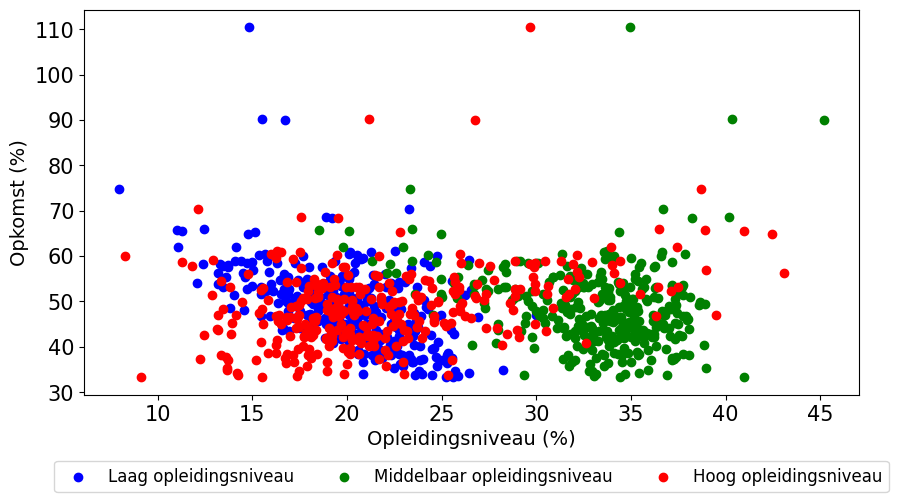

In [125]:
# Create scatter plots
plt.figure(figsize=(10, 5))

# Scatter plots
plt.scatter(voting_data_gm['a_opl_lgn'], voting_data_gm['opkomst'], label='Laag opleidingsniveau', color='blue', alpha=1)
plt.scatter(voting_data_gm['a_opl_mdn'], voting_data_gm['opkomst'], label='Middelbaar opleidingsniveau', color='green', alpha=1)
plt.scatter(voting_data_gm['a_opl_hgn'], voting_data_gm['opkomst'], label='Hoog opleidingsniveau', color='red', alpha=1)

# Adding KDE plots
#sns.kdeplot(x=voting_data_wijk_100_non_zero['a_opl_lgn'], y=voting_data_wijk_100_non_zero['opkomst'], color='blue', alpha=0.1, fill=True)
#sns.kdeplot(x=voting_data_wijk_100_non_zero['a_opl_mdn'], y=voting_data_wijk_100_non_zero['opkomst'], color='green', alpha=0.1, fill=True)
#sns.kdeplot(x=voting_data_wijk_100_non_zero['a_opl_hgn'], y=voting_data_wijk_100_non_zero['opkomst'], color='red', alpha=0.1, fill=True)

# Adding labels and legend in Dutch with text size adjustments
plt.xlabel('Opleidingsniveau (%)', fontsize=14)
plt.ylabel('Opkomst (%)', fontsize=14)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fontsize=12, ncol=3)
#plt.title('Opleiding vs. Opkomst', fontsize=16)
# Adjusting tick size
plt.tick_params(axis='both', which='major', labelsize=15)

plt.savefig("Analyse///Gemeente_opkomst//Education"+_suffix_gm+".png", format='png', dpi=500, bbox_inches='tight', transparent=True)
# Show plot
plt.show()

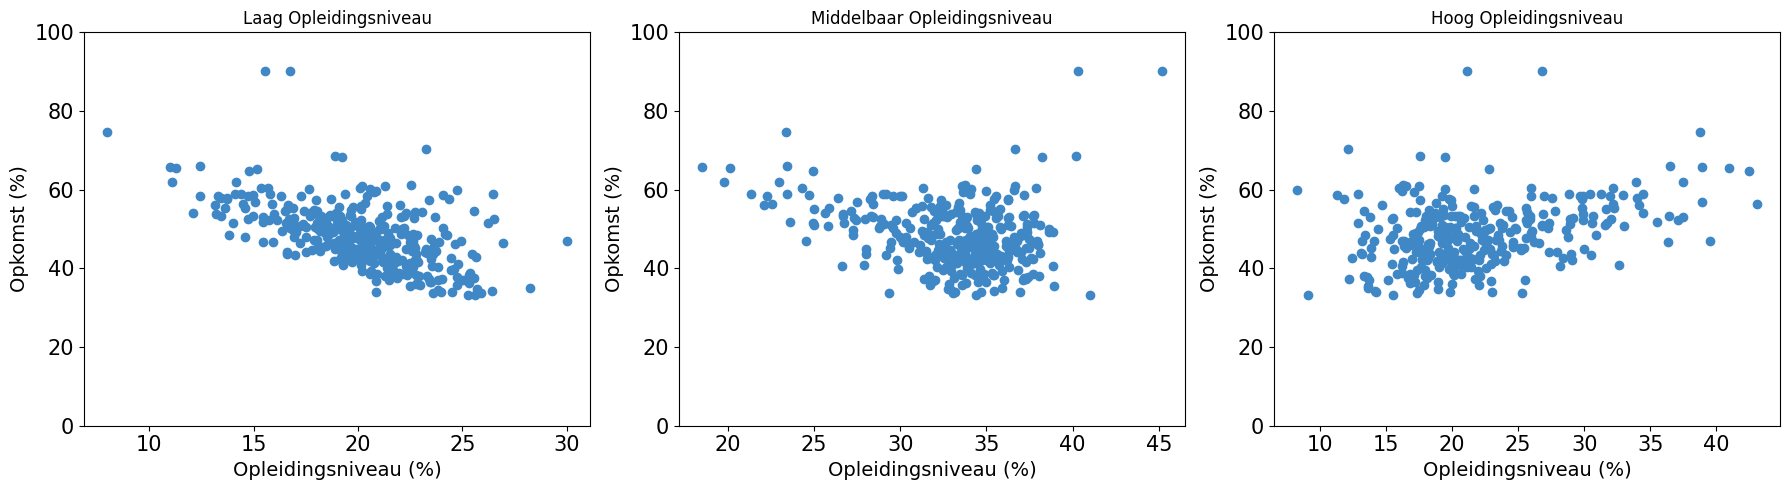

In [126]:
# Assuming voting_data_gm is a DataFrame with the required columns
# and _suffix_gm is a string used in the file name

# Create a figure with 3 subplots, arranged vertically
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Scatter plot for Laag opleidingsniveau
axs[0].scatter(voting_data_gm['a_opl_lgn'], voting_data_gm['opkomst'], label='Laag opleidingsniveau', color='#3f88c5', alpha=1)
axs[0].set_xlabel('Opleidingsniveau (%)', fontsize=14)
axs[0].set_ylabel('Opkomst (%)', fontsize=14)
#axs[0].legend(loc='upper right', fontsize=12)
axs[0].tick_params(axis='both', which='major', labelsize=15)
axs[0].set_ylim(0, 100)
axs[0].set_title('Laag Opleidingsniveau')

# Scatter plot for Middelbaar opleidingsniveau
axs[1].scatter(voting_data_gm['a_opl_mdn'], voting_data_gm['opkomst'], label='Middelbaar opleidingsniveau', color='#3f88c5', alpha=1)
axs[1].set_xlabel('Opleidingsniveau (%)', fontsize=14)
axs[1].set_ylabel('Opkomst (%)', fontsize=14)
#axs[1].legend(loc='upper right', fontsize=12)
axs[1].tick_params(axis='both', which='major', labelsize=15)
axs[1].set_ylim(0, 100)
axs[1].set_title('Middelbaar Opleidingsniveau')

# Scatter plot for Hoog opleidingsniveau
axs[2].scatter(voting_data_gm['a_opl_hgn'], voting_data_gm['opkomst'], label='Hoog opleidingsniveau', color='#3f88c5', alpha=1)
axs[2].set_xlabel('Opleidingsniveau (%)', fontsize=14)
axs[2].set_ylabel('Opkomst (%)', fontsize=14)
#axs[2].legend(loc='upper right', fontsize=12)
axs[2].tick_params(axis='both', which='major', labelsize=15)
axs[2].set_ylim(0, 100)
axs[2].set_title('Hoog Opleidingsniveau')

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure with the specified formatting options
plt.savefig("Analyse///Gemeente_opkomst//Education_subplot"+_suffix_gm+".png", format='png', dpi=500, bbox_inches='tight', transparent=True)

# Show plot
plt.show()


In [127]:
for edu in ['a_opl_lgn', 'a_opl_mdn', 'a_opl_hgn']:
    # Calculate and print Pearson correlation coefficient and p-value 
    ed_pearsonr = pearsonr(voting_data_gm[edu], voting_data_gm['opkomst'])
    print(f"Pearson correlation (education and turnout): Coefficient = {ed_pearsonr[0]:.3f}, p-value = {ed_pearsonr[1]:.3g},education_level  = {edu}{_suffix_gm}")


Pearson correlation (education and turnout): Coefficient = -0.544, p-value = 8.93e-28,education_level  = a_opl_lgn_500
Pearson correlation (education and turnout): Coefficient = -0.213, p-value = 7.09e-05,education_level  = a_opl_mdn_500
Pearson correlation (education and turnout): Coefficient = 0.354, p-value = 1.54e-11,education_level  = a_opl_hgn_500


## Income

In [128]:
voting_data_gm[voting_data_gm['gemeente']=='Schiermonnikoog']#['g_hh_sti']

,gemeenteId,kiesgerechtigden,uitgebrachte_stemmen,opkomst,gemeente,gemeentecode,inwoners,woningwaarde,uitkering,dist_mean,...,recs,a_inw,a_opl_lg,a_opl_md,a_opl_hg,g_hh_sti,municipality_type,a_opl_lgn,a_opl_mdn,a_opl_hgn
12,GM0088,803,887,110.460772,Schiermonnikoog,GM0088,935,389.857143,40,443.10239,...,Gemeente,944,140,330,280,NaN,Kleine,14.830508,34.957627,29.661017


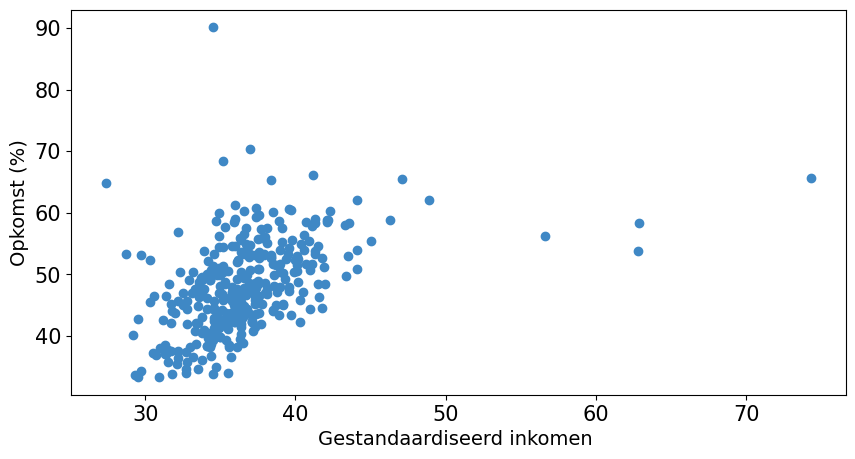

In [129]:
# Create scatter plots
plt.figure(figsize=(10, 5))

# Scatter plots
plt.scatter(voting_data_gm['g_hh_sti'], voting_data_gm['opkomst'], color = '#3f88c5', alpha=1)


# Adding labels and legend in Dutch with text size adjustments
plt.xlabel('Gestandaardiseerd inkomen ', fontsize=14)
plt.ylabel('Opkomst (%)', fontsize=14)
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fontsize=12, ncol=3)
#plt.title('Inkomen  vs. Opkomst', fontsize=16)
# Adjusting tick size
plt.tick_params(axis='both', which='major', labelsize=15)

plt.savefig("Analyse///Gemeente_opkomst//Income"+_suffix_gm+".png", format='png', dpi=500, bbox_inches='tight', transparent=True)
# Show plot
plt.show()

In [130]:
ink = "g_hh_sti"
voting_data_gm_income = voting_data_gm.dropna(subset = ['g_hh_sti'])
income_pearsonr = pearsonr(voting_data_gm_income['g_hh_sti'], voting_data_gm_income['opkomst'])
print(f"Pearson correlation (income and turnout): Coefficient = {income_pearsonr[0]:.3f}, p-value = {income_pearsonr[1]:.3g},income_level  = {ink}{_suffix_gm}")


Pearson correlation (income and turnout): Coefficient = 0.460, p-value = 5.13e-19,income_level  = g_hh_sti_500


## Distance

In [131]:
for gm_size in voting_data_gm.municipality_type.unique():
    turn_up_vs_distance_size = voting_data_gm[voting_data_gm.municipality_type==gm_size]
    print(f"Size of {gm_size} : {len(turn_up_vs_distance_size)}")
    # Calculate and print Pearson correlation coefficient and p-value for mean distance and turnout fraction
    mean_distance_pearsonr = pearsonr(turn_up_vs_distance_size['dist_mean'], turn_up_vs_distance_size['opkomst'])
    print(f"Pearson correlation (mean distance and turnout): Coefficient = {mean_distance_pearsonr[0]:.3f}, p-value = {mean_distance_pearsonr[1]:.3g},type_ = {_suffix_gm}")

    # Calculate and print Pearson correlation coefficient and p-value for median distance and turnout fraction
    median_distance_pearsonr = pearsonr(turn_up_vs_distance_size['dist_median'], turn_up_vs_distance_size['opkomst'])
    print(f"Pearson correlation (median distance and turnout): Coefficient = {median_distance_pearsonr[0]:.3f}, p-value = {median_distance_pearsonr[1]:.3g},type_ = {_suffix_gm}")

Size of Grote : 18
Pearson correlation (mean distance and turnout): Coefficient = -0.258, p-value = 0.302,type_ = _500
Pearson correlation (median distance and turnout): Coefficient = -0.266, p-value = 0.287,type_ = _500
Size of Kleine : 208
Pearson correlation (mean distance and turnout): Coefficient = 0.097, p-value = 0.165,type_ = _500
Pearson correlation (median distance and turnout): Coefficient = 0.043, p-value = 0.536,type_ = _500
Size of Middelgrote : 116
Pearson correlation (mean distance and turnout): Coefficient = 0.155, p-value = 0.0962,type_ = _500
Pearson correlation (median distance and turnout): Coefficient = -0.076, p-value = 0.42,type_ = _500


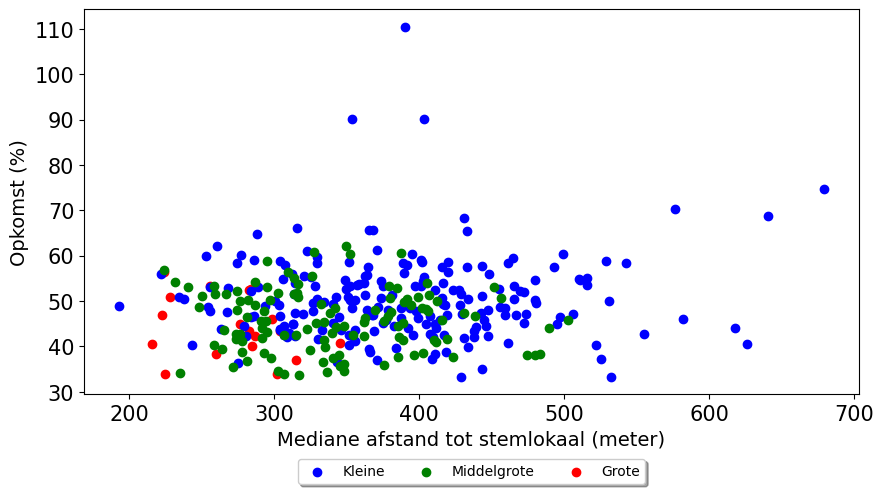

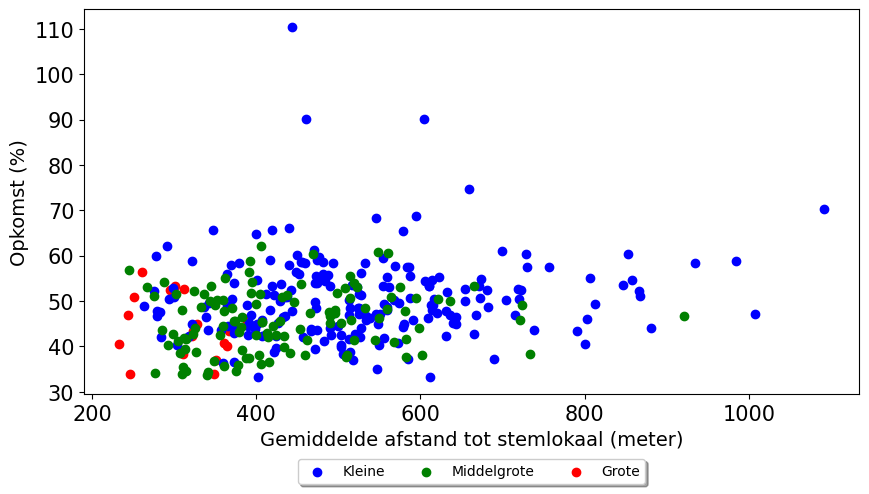

In [132]:
# Function to plot scatter plots for 'dist_median' and 'dist_mean' against 'Fraction_turn_up'

def plot_turn_up_vs_distance(data, x_column, x_label, file_name):
    plt.rcParams["figure.figsize"] = [10, 5]
    fig, ax = plt.subplots()  # Create a figure and axis object

    # Define colors for each municipality type
    colors = {'Kleine': 'blue', 'Middelgrote': 'green', 'Grote': 'red'}

    # Iterate over each 'municipality_type' to scatter plot with different colors
    for municipality_type, group in data.groupby('municipality_type'):
        ax.scatter(group[x_column], group['opkomst'], label=municipality_type, color=colors[municipality_type])
    
    # Sort the legend labels
    handles, labels = ax.get_legend_handles_labels()
    desired_order = ['Kleine', 'Middelgrote', 'Grote']
    ordered_handles = [handles[labels.index(label)] for label in desired_order]
    ordered_labels = [label for label in desired_order]

    # Create legend with the specified order and custom settings
    ax.legend(ordered_handles, ordered_labels, loc='upper center', bbox_to_anchor=(0.5, -0.15),
              fancybox=True, shadow=True, ncol=3)
    
    # Set plot limits and labels with custom fonts
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel(x_label, fontsize=14)
    plt.ylabel('Opkomst (%)', fontsize=14)

    # Save the figure
    plt.savefig(file_name, bbox_inches='tight')
    
        # Save the plot to a file
    plt.savefig("Analyse///Gemeente_opkomst//"+file_name+_suffix_gm+".png", format='png', dpi=500, bbox_inches='tight', transparent=True)
    plt.show()

# Plot for median distance
plot_turn_up_vs_distance(voting_data_gm, 'dist_median', 'Mediane afstand tot stemlokaal (meter)', 'Dist_medianVsVoting_gemeenteSize.png')

# Plot for mean distance
plot_turn_up_vs_distance(voting_data_gm, 'dist_mean', 'Gemiddelde afstand tot stemlokaal (meter)', 'Dist_meanVsVoting_gemeenteSize.png')



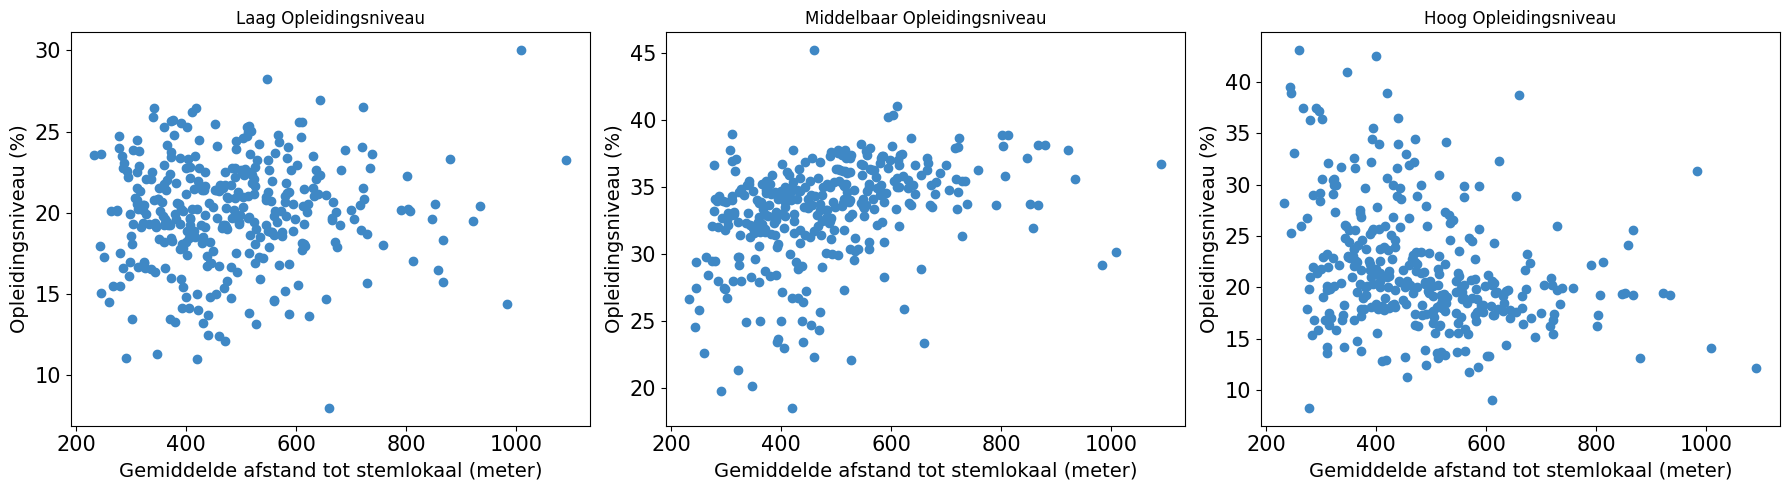

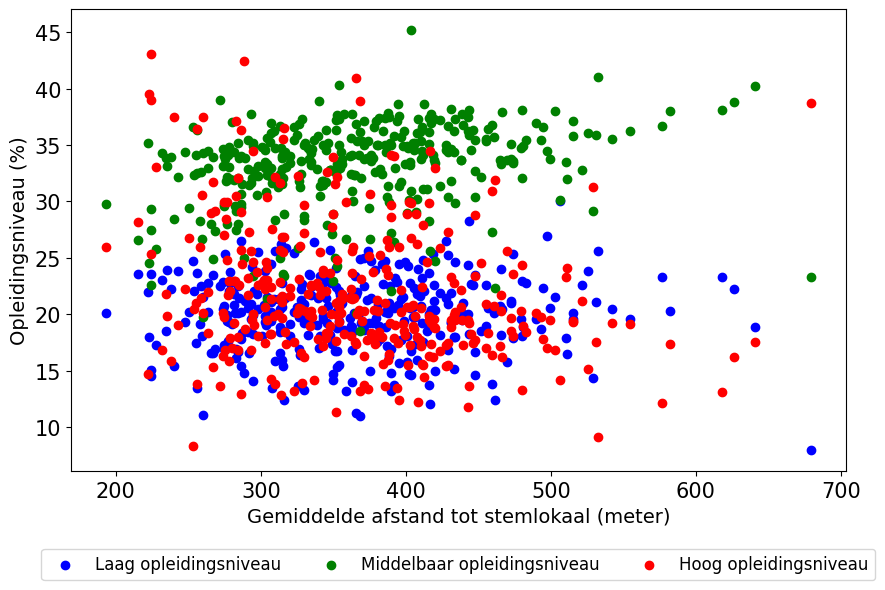

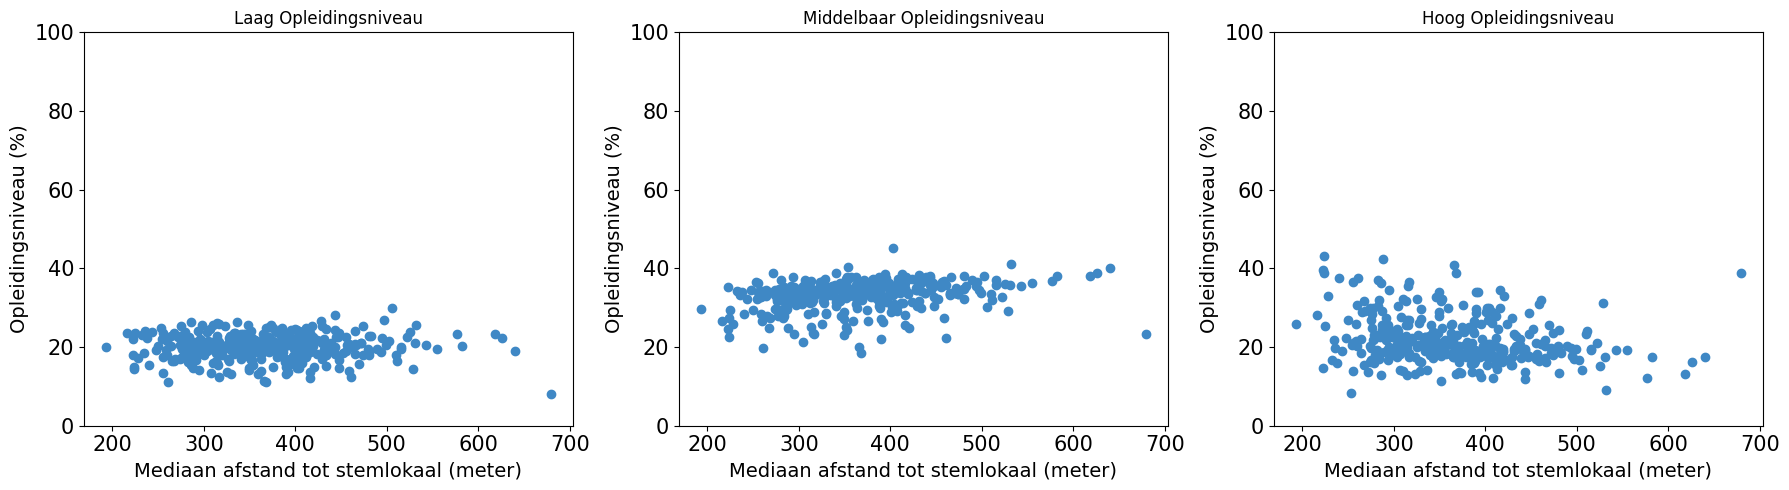

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


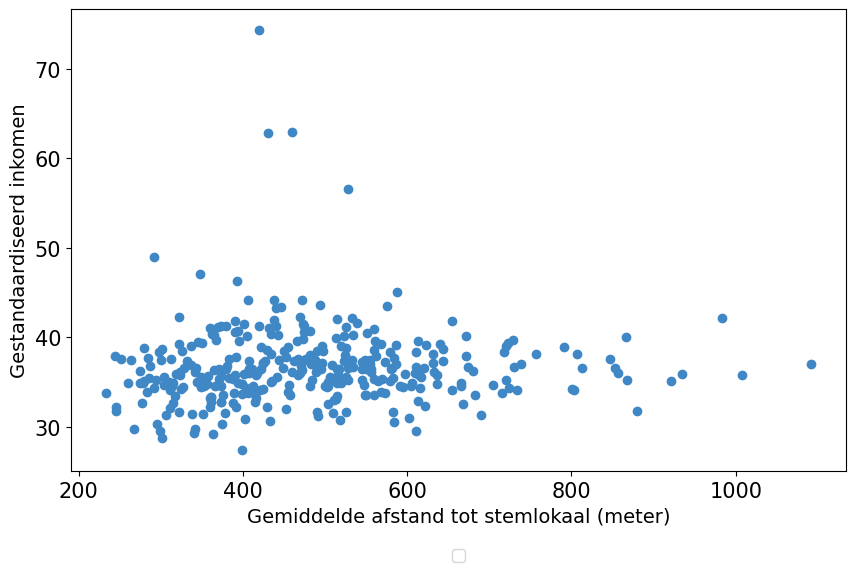

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


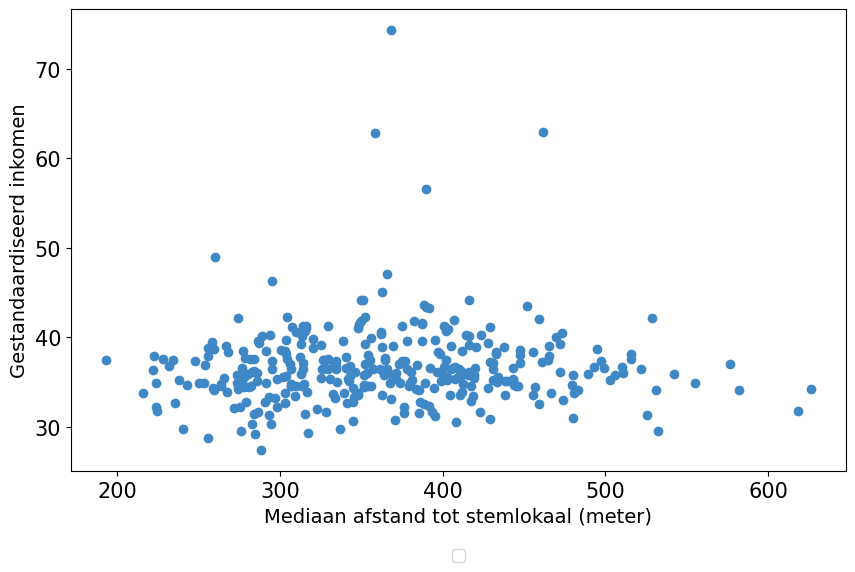

In [133]:


# Define the figure size and the subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# First subplot for Laag opleidingsniveau
ax1.scatter(voting_data_gm['dist_mean'], voting_data_gm['a_opl_lgn'], color='#3f88c5', alpha=1)
ax1.set_ylabel('Opleidingsniveau (%)', fontsize=14)
ax1.set_xlabel('Gemiddelde afstand tot stemlokaal (meter)', fontsize=14)
ax1.set_title('Laag Opleidingsniveau')
ax1.tick_params(axis='both', which='major', labelsize=15)

# Second subplot for Middelbaar opleidingsniveau
ax2.scatter(voting_data_gm['dist_mean'], voting_data_gm['a_opl_mdn'], color='#3f88c5', alpha=1)
ax2.set_ylabel('Opleidingsniveau (%)', fontsize=14)
ax2.set_xlabel('Gemiddelde afstand tot stemlokaal (meter)', fontsize=14)
ax2.set_title('Middelbaar Opleidingsniveau')
ax2.tick_params(axis='both', which='major', labelsize=15)

# Third subplot for Hoog opleidingsniveau
ax3.scatter(voting_data_gm['dist_mean'], voting_data_gm['a_opl_hgn'], color='#3f88c5', alpha=1)
ax3.set_ylabel('Opleidingsniveau (%)', fontsize=14)
ax3.set_xlabel('Gemiddelde afstand tot stemlokaal (meter)', fontsize=14)
ax3.set_title('Hoog Opleidingsniveau')
ax3.tick_params(axis='both', which='major', labelsize=15)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig("Analyse//Gemeente_spread//dist_mean_Education_subplot"+_suffix_gm+".png", format='png', dpi=500, bbox_inches='tight', transparent=True)
# Show plot
plt.show()

# Scatter plots
plt.figure(figsize=(10, 6))
plt.scatter(voting_data_gm['dist_median'],voting_data_gm['a_opl_lgn'], label='Laag opleidingsniveau', color='blue', alpha=1)
plt.scatter(voting_data_gm['dist_median'],voting_data_gm['a_opl_mdn'], label='Middelbaar opleidingsniveau', color='green', alpha=1)
plt.scatter(voting_data_gm['dist_median'],voting_data_gm['a_opl_hgn'], label='Hoog opleidingsniveau', color='red', alpha=1)

# Adding labels and legend in Dutch with text size adjustments
plt.ylabel('Opleidingsniveau (%)', fontsize=14)
plt.xlabel('Gemiddelde afstand tot stemlokaal (meter)', fontsize=14)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fontsize=12, ncol=3)
#plt.title('Opleiding vs. Opkomst', fontsize=16)
# Adjusting tick size
plt.tick_params(axis='both', which='major', labelsize=15)

#plt.savefig("Analyse///Gemeente_spread//dist_median_Education"+_suffix_gm+".png", format='png', dpi=500, bbox_inches='tight', transparent=True)
# Show plot
plt.show()
                                                        
# Define the figure size and the subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# First subplot for Laag opleidingsniveau
ax1.scatter(voting_data_gm['dist_median'], voting_data_gm['a_opl_lgn'], color='#3f88c5', alpha=1)
ax1.set_ylabel('Opleidingsniveau (%)', fontsize=14)
ax1.set_xlabel('Mediaan afstand tot stemlokaal (meter)', fontsize=14)
ax1.set_title('Laag Opleidingsniveau')
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.set_ylim(0, 100)

# Second subplot for Middelbaar opleidingsniveau
ax2.scatter(voting_data_gm['dist_median'], voting_data_gm['a_opl_mdn'], color='#3f88c5', alpha=1)
ax2.set_ylabel('Opleidingsniveau (%)', fontsize=14)
ax2.set_xlabel('Mediaan afstand tot stemlokaal (meter)', fontsize=14)
ax2.set_title('Middelbaar Opleidingsniveau')
ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.set_ylim(0, 100)

# Third subplot for Hoog opleidingsniveau
ax3.scatter(voting_data_gm['dist_median'], voting_data_gm['a_opl_hgn'], color='#3f88c5', alpha=1)
ax3.set_ylabel('Opleidingsniveau (%)', fontsize=14)
ax3.set_xlabel('Mediaan afstand tot stemlokaal (meter)', fontsize=14)
ax3.set_title('Hoog Opleidingsniveau')
ax3.tick_params(axis='both', which='major', labelsize=15)
ax3.set_ylim(0, 100)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig("G://Projecten//Data Science//8698_Kiesraad - Meting stemlokalen EP24//4. Analyse///Gemeente_spread//dist_median_Education_subplot"+_suffix_gm+".png", format='png', dpi=500, bbox_inches='tight', transparent=True)

# Show plot
plt.show()                                                        


# Scatter plots
plt.figure(figsize=(10, 6))
plt.scatter(voting_data_gm_income['dist_mean'],voting_data_gm_income['g_hh_sti'], color='#3f88c5', alpha=1)

# Adding labels and legend in Dutch with text size adjustments
plt.ylabel('Gestandaardiseerd inkomen', fontsize=14)
plt.xlabel('Gemiddelde afstand tot stemlokaal (meter)', fontsize=14)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fontsize=12, ncol=3)
#plt.title('Opleiding vs. Opkomst', fontsize=16)
# Adjusting tick size
plt.tick_params(axis='both', which='major', labelsize=15)

plt.savefig("Analyse///Gemeente_spread//dist_mean_income"+_suffix_gm+".png", format='png', dpi=500, bbox_inches='tight', transparent=True)
# Show plot
plt.show()

# Scatter plots
plt.figure(figsize=(10, 6))
plt.scatter(voting_data_gm_income['dist_median'], voting_data_gm_income['g_hh_sti'], color='#3f88c5', alpha=1)

# Adding labels and legend in Dutch with text size adjustments
plt.ylabel('Gestandaardiseerd inkomen', fontsize=14)
plt.xlabel('Mediaan afstand tot stemlokaal (meter)', fontsize=14)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fontsize=12, ncol=3)
#plt.title('Opleiding vs. Opkomst', fontsize=16)
# Adjusting tick size
plt.tick_params(axis='both', which='major', labelsize=15)

plt.savefig("Analyse///Gemeente_spread//dist_median_income"+_suffix_gm+".png", format='png', dpi=500, bbox_inches='tight', transparent=True)
# Show plot
plt.show()


In [134]:
for edu in ['a_opl_lg', 'a_opl_md', 'a_opl_hg']:
    # Calculate and print Pearson correlation coefficient and p-value 
    ed_pearsonr = pearsonr(voting_data_gm[edu], voting_data_gm['dist_mean'])
    print(f"Pearson correlation (education and dist_mean): Coefficient = {ed_pearsonr[0]:.3f}, p-value = {ed_pearsonr[1]:.3g},education_level  = {edu}{_suffix_gm}")
    ed_pearsonr = pearsonr(voting_data_gm[edu], voting_data_gm['dist_median'])
    print(f"Pearson correlation (education and dist_median): Coefficient = {ed_pearsonr[0]:.3f}, p-value = {ed_pearsonr[1]:.3g},education_level  = {edu}{_suffix_gm}")

voting_data_gm_wo_nan = voting_data_gm.dropna(subset = 'g_hh_sti')    
ed_pearsonr = pearsonr(voting_data_gm_wo_nan['g_hh_sti'], voting_data_gm_wo_nan['dist_median'])
print(f"Pearson correlation (income and dist_median): Coefficient = {ed_pearsonr[0]:.3f}, p-value = {ed_pearsonr[1]:.3g}")

ed_pearsonr = pearsonr(voting_data_gm_wo_nan['g_hh_sti'], voting_data_gm_wo_nan['dist_mean'])
print(f"Pearson correlation (income and dist_mean): Coefficient = {ed_pearsonr[0]:.3f}, p-value = {ed_pearsonr[1]:.3g}")


Pearson correlation (education and dist_mean): Coefficient = -0.333, p-value = 2.52e-10,education_level  = a_opl_lg_500
Pearson correlation (education and dist_median): Coefficient = -0.341, p-value = 9e-11,education_level  = a_opl_lg_500
Pearson correlation (education and dist_mean): Coefficient = -0.347, p-value = 3.84e-11,education_level  = a_opl_md_500
Pearson correlation (education and dist_median): Coefficient = -0.360, p-value = 6.59e-12,education_level  = a_opl_md_500
Pearson correlation (education and dist_mean): Coefficient = -0.321, p-value = 1.23e-09,education_level  = a_opl_hg_500
Pearson correlation (education and dist_median): Coefficient = -0.329, p-value = 4.22e-10,education_level  = a_opl_hg_500
Pearson correlation (income and dist_median): Coefficient = 0.051, p-value = 0.349
Pearson correlation (income and dist_mean): Coefficient = 0.047, p-value = 0.392
